In [21]:
from random import random, seed, randrange
from math import floor, pi
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
import pandas as pd
from scipy.integrate import simps, trapz, cumtrapz
from scipy.ndimage.filters import gaussian_filter1d
from time import time
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 9]

In [22]:
%run -i "..\carbon_walls\gcmc.py"

In [42]:
yco = 0.5
P_res = 200*10**5 #[Pa]
T = 45 + 273.15 #K
fco, fme = PR_Fugacity( P_res/10**5, T, yco )
fco = fco*10**5
fme = fme*10**5

del_sf = 3.35 #[A]
rho_sf = 0.114 #[A^-3]
W = 5*3.8 #[A] relative to diameter of methane 3.80A
sf = False
mega_verbose = False

s_box = 57.15
N_max = 50000
Vol = s_box**3
kb = 1.3806*10**(7) #[Pa*A^3/K]
Nco = 0 #floor(fco*Vol/kb/T)
Nme = 0 #floor(fme*Vol/kb/T)
Nc = 0
rc = s_box
beta = 1/T
zz_co = beta*fco
zz_me = beta*fme
delta = 1
pi_move = 0.5

N_moves = 100
N_equil = 0
N_prod = int( np.round( 500000/N_moves) )


In [43]:
rhocov,rhomev,Env,Pv,Ncov, Nmev = mc_run(verbose = True)

0 yco:  0.539 N:  9.0 P:  2.12 En:  -0.63 Accept%: 1.0 1.0 0.0
500 yco:  0.46 N:  1101.0 P:  160.91 En:  -362.83 Accept%: 0.51 0.407 0.317
1000 yco:  0.505 N:  1343.0 P:  221.74 En:  -455.9 Accept%: 0.502 0.247 0.236
1500 yco:  0.491 N:  1373.0 P:  221.23 En:  -459.92 Accept%: 0.505 0.22 0.218
2000 yco:  0.477 N:  1332.0 P:  175.99 En:  -454.21 Accept%: 0.507 0.216 0.218
2500 yco:  0.492 N:  1317.0 P:  189.12 En:  -463.33 Accept%: 0.498 0.217 0.218
3000 yco:  0.52 N:  1398.0 P:  200.76 En:  -479.74 Accept%: 0.5 0.205 0.201
3500 yco:  0.524 N:  1374.0 P:  173.02 En:  -467.84 Accept%: 0.505 0.192 0.195
4000 yco:  0.51 N:  1372.0 P:  177.7 En:  -460.77 Accept%: 0.497 0.203 0.205
4500 yco:  0.517 N:  1366.0 P:  216.86 En:  -471.59 Accept%: 0.504 0.209 0.205


In [44]:
output = pd.DataFrame()
output['rhocov'] = rhocov
output['rhomev'] = rhomev
output['Env'] = Env
output['Pv'] = Pv
output['Ncov'] = Ncov
output['Nmev'] = Nmev

In [45]:
rhocov.mean() + rhomev.mean()

0.006935263552563764

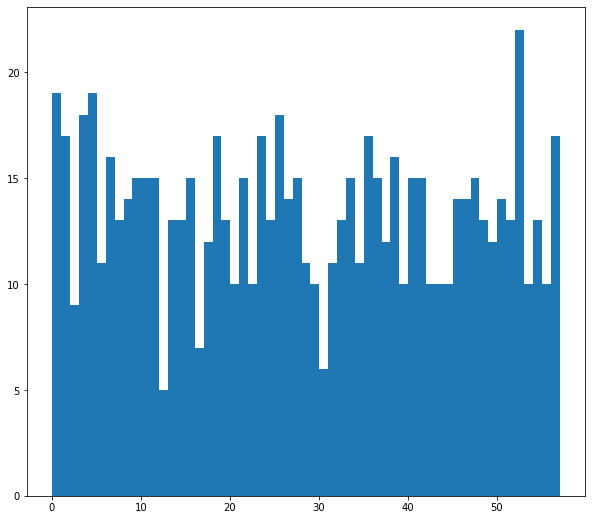

In [46]:
Zco = pd.array(Zco)
useful_z = Zco[ Zco > 0 ]
plt.hist( useful_z, bins=57 )
plt.show()

Text(0.5, 0, 'Cycles (100 steps/cycle)')

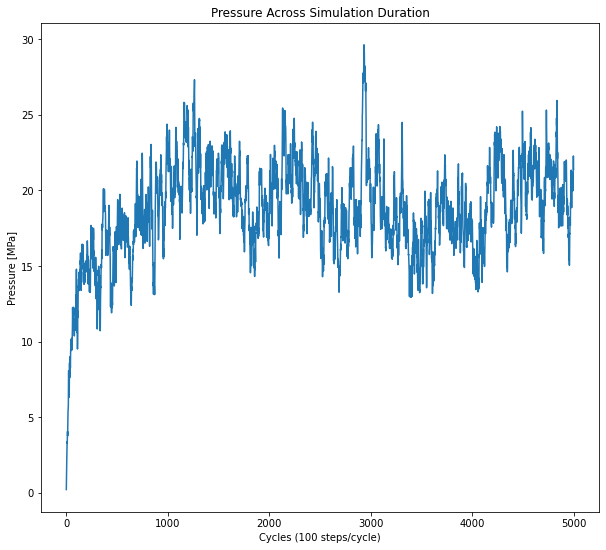

In [52]:
plt.plot( output.Pv )
plt.title("Pressure Across Simulation Duration")
plt.ylabel("Pressure [MPa]")
plt.xlabel("Cycles (100 steps/cycle)")

Text(0.5, 0, 'Cycles (100 steps/cycle)')

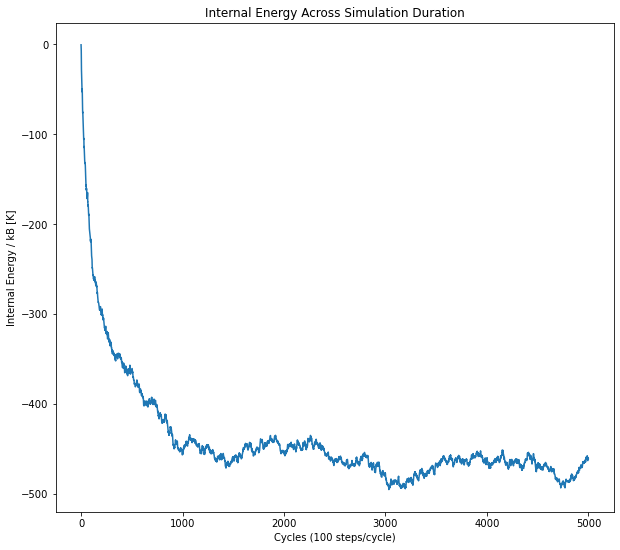

In [53]:
plt.plot( output.Env )
plt.title("Internal Energy Across Simulation Duration")
plt.ylabel("Internal Energy / kB [K]")
plt.xlabel("Cycles (100 steps/cycle)")

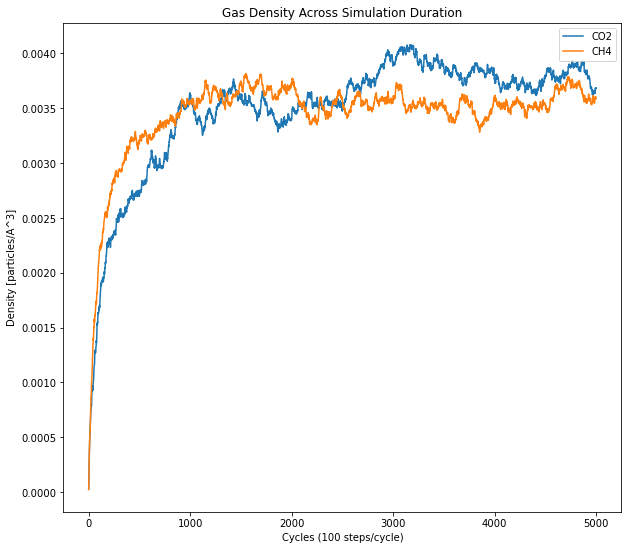

In [54]:
plt.plot( output.rhocov, label = "CO2" )
plt.plot( output.rhomev, label = "CH4" )
plt.title("Gas Density Across Simulation Duration")
plt.ylabel("Density [particles/A^3]")
plt.xlabel("Cycles (100 steps/cycle)")
plt.legend()

Text(0.5, 0, 'Cycles (100 steps/cycle)')

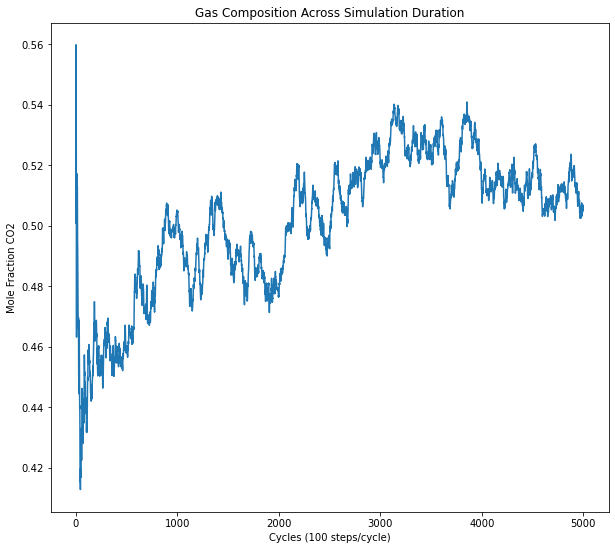

In [56]:
plt.plot( Ncov/(Ncov+Nmev)  )
plt.title("Gas Composition Across Simulation Duration")
plt.ylabel("Mole Fraction CO2")
plt.xlabel("Cycles (100 steps/cycle)")

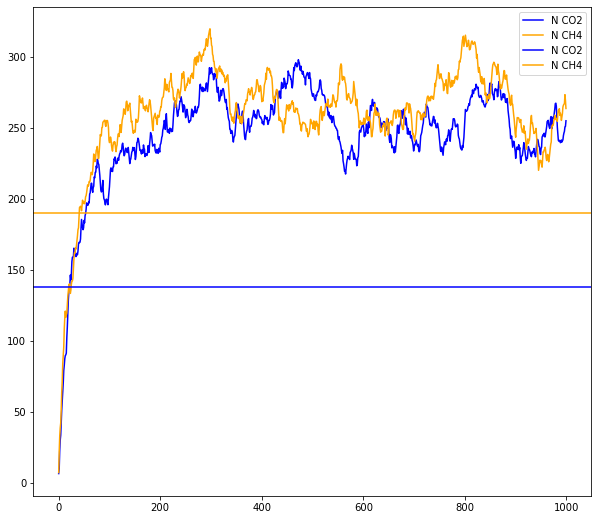

In [30]:
plt.plot( output.Ncov, label = "N CO2", color = "blue" )
plt.plot( output.Nmev, label = "N CH4", color = "orange")
plt.axhline(  fco*Vol/kb/T,  label = "N CO2", color = "blue")
plt.axhline(  fme*Vol/kb/T,  label = "N CH4", color = "orange")
# plt.plot( fme*Vol/kb/T, xmin = 0, xmax = N_equil, label = "Res CH4")
plt.legend()

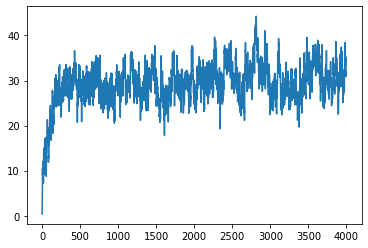

In [10]:
plt.plot( output.Pv )

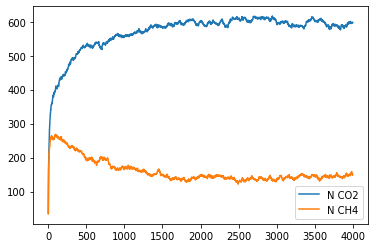

In [11]:
plt.plot( output.Ncov, label = "N CO2" )
plt.plot( output.Nmev, label = "N CH4")
plt.legend()

In [25]:
Nex = Ncov.mean() - fco*Vol/kb/T
print( Nex )

# Getting results in terms of particles
4*6.02*Vol/10**4

393.9296821601084


449.474633307

In [12]:
def Usf( z, eps, sig):
    # Potential Energy of a particle
    
    A = 2*pi*eps*rho_sf*sig**2*del_sf
    
    d = z
    #print( "Xme", Xme[Nme-1], "Xco", Xco[Nco-1], "Nco", Nco, "Nme", Nme, "d", d)
    #if( d < 0.00001 ):
        #raise ValueError('A very specific bad thing happened.')
    ui = A*( 2/5*(sig/d)**10 - (sig/d)**4 - sig**4/( 3*del_sf*(d+0.61*del_sf)**3 ) )
    fi = 4*A*( (sig/d)**10 - (sig/d)**4 - sig**4*d/(4*del_sf*(d + 0.61*del_sf)**4) )

    d = W - z
    ui = ui + A*( 2/5*(sig/d)**10 - (sig/d)**4 - sig**4/( 3*del_sf*(d+0.61*del_sf)**3 ) )
    
    fi = fi + 4*A*( (sig/d)**10 - (sig/d)**4 - sig**4*d/(4*del_sf*(d + 0.61*del_sf)**4) )
    
    return ui, fi
    

In [25]:
resolution = 1000
Esfv = np.zeros(resolution)
Fsfv = np.zeros(resolution)
Zv = np.linspace(2.9,W-2.9,resolution)
for i in range(resolution):
    Esf, Fsf = Usf( Zv[i], e_cosf, s_cosf )
    Esfv[i] = Esf
    Fsfv[i] = Fsf

    
Ecov = np.zeros(resolution)
Fcov = np.zeros(resolution)
rv = np.linspace(3.3,W,resolution)
for i in range(resolution):
    Eco, Fco = Ui( rv[i]**2, e_co, s_co)
    Ecov[i] = Eco
    Fcov[i] = Fco

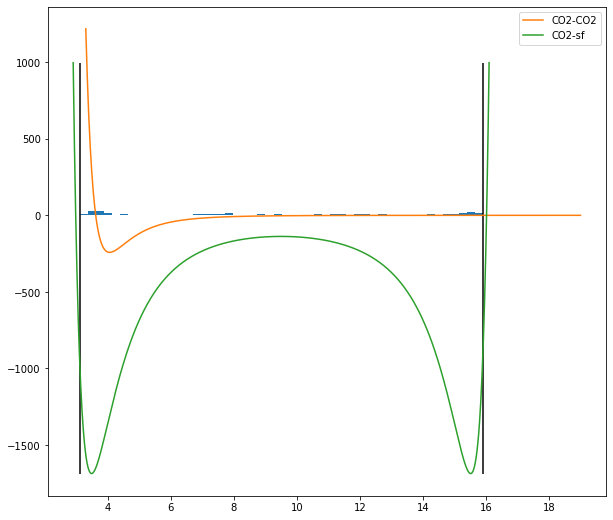

In [164]:
plt.hist( useful_z, bins=50 )
plt.plot( rv, Ecov, label = "CO2-CO2" )
plt.plot( Zv, Esfv, label = "CO2-sf" )
plt.vlines( min( useful_z), ymin = max( Esfv) , ymax = min( Esfv ))
plt.vlines( max( useful_z), ymin = max( Esfv) , ymax = min( Esfv ))
plt.legend()

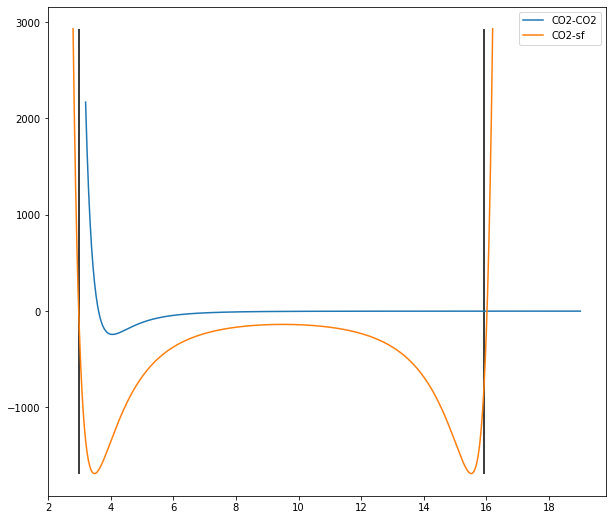

In [281]:
plt.plot( rv, Ecov, label = "CO2-CO2" )
plt.plot( Zv, Esfv, label = "CO2-sf" )
plt.vlines( min( useful_z), ymin = max( Esfv) , ymax = min( Esfv ))
plt.vlines( max( useful_z), ymin = max( Esfv) , ymax = min( Esfv ))
plt.legend()

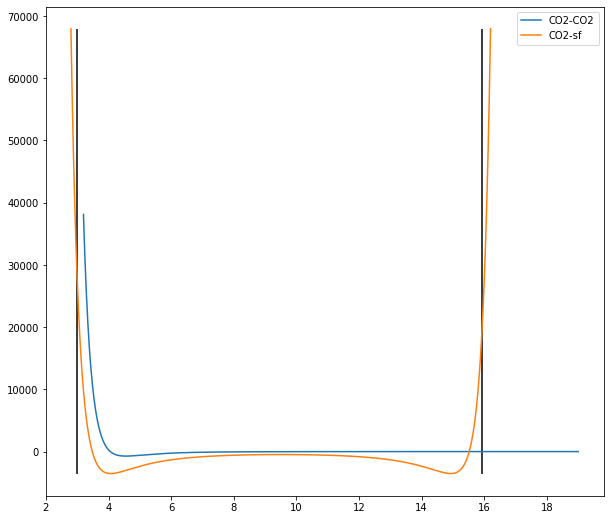

In [276]:
plt.plot( rv, Fcov, label = "CO2-CO2"  )
plt.plot( Zv, Fsfv, label = "CO2-sf" )
plt.vlines( min( useful_z), ymin = max( Fsfv) , ymax = min( Fsfv ))
plt.vlines( max( useful_z), ymin = max( Fsfv) , ymax = min( Fsfv ))

plt.legend()

In [267]:
Usf( 10, e_cosf, s_cosf )

(-140.85192131594883, -488.9029407287462)

In [270]:
min( useful_z )

2.9856882908768374

In [271]:
max( useful_z )

15.928065030180896